Based on single LightGBM baseline with minimal FE, LB **0.447**:

https://www.kaggle.com/code/snufkin77/mcts-strength-relevant-baseline

DeepTables: Deep-learning Toolkit for Tabular data

https://github.com/DataCanvasIO/DeepTables

https://deeptables.readthedocs.io/en/latest/model_config.html#parameters

**Version 1**: single DeepTables NN baseline, LB **0.462**.

**Version 6**: single DeepTables NN, LB **0.448**; `ModelConfig(apply_gbm_features=True)`.

**Version 7**: single DeepTables NN, LB **0.438**; `ModelConfig(apply_gbm_features=True)`, `ModelConfig(nets=['dnn_nets'] + ['fm_nets'] + ['cin_nets'])`.

**Version 8**: same as Version 7 + scaling all numerical features to fix issue with divergence in the validation scores. Now overall CV rmse (0.4324) is closer to LB **0.435**. Note that in this version, the `fit_transform` method of scaler was performed on train and test data combined, which is not a good practice, although it does not violate any Kaggle rules.

**Version 9**: same as Version 8, but using scaler with `fit_transform` on the training data alone and then applying `transform` to the test data. CV 0.4319 | LB **0.438**.

**Version 10**: scaling way from Version 9, enabling `LearningRateScheduler` with warmup (`LR_START = 1e-4`) on first epoch.

In [1]:
!pip install --no-index -U --find-links=/kaggle/input/tensorflow-2-15/tensorflow tensorflow==2.15.0
!pip install --no-index -U --find-links=/kaggle/input/deeptables-v0-2-5/deeptables-0.2.5 deeptables==0.2.5

Looking in links: /kaggle/input/tensorflow-2-15/tensorflow
Processing /kaggle/input/tensorflow-2-15/tensorflow/tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /kaggle/input/tensorflow-2-15/tensorflow/ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from tensorflow==2.15.0)
Processing /kaggle/input/tensorflow-2-15/tensorflow/wrapt-1.14.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from tensorflow==2.15.0)
Processing /kaggle/input/tensorflow-2-15/tensorflow/tensorboard-2.15.1-py3-none-any.whl (from tensorflow==2.15.0)
Processing /kaggle/input/tensorflow-2-15/tensorflow/keras-2.15.0-py3-none-any.whl (from tensorflow==2.15.0)
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalli

In [2]:
import os
import math
import random
import warnings
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, polars as pl
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
from colorama import Fore, Style

import tensorflow as tf, deeptables as dt
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.legacy import Adam
from deeptables.models import DeepTable, ModelConfig
from deeptables.models import deepnets

import kaggle_evaluation.mcts_inference_server

warnings.filterwarnings('ignore')
print('TensorFlow version:',tf.__version__+',',
      'GPU =',tf.test.is_gpu_available())
print('DeepTables version:',dt.__version__)

2024-10-19 10:25:57.425810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 10:25:57.425885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 10:25:57.427306: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0, GPU = True
DeepTables version: 0.2.5


In [3]:
seed = 42
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(seed=seed)

In [4]:
constant_cols = pd.read_csv('/kaggle/input/um-gps-of-mcts-variants-constant-columns/constant_columns.csv').columns.to_list()
target_col = 'utility_agent1'
game_col = 'GameRulesetName'
game_rule_cols = ['EnglishRules', 'LudRules']
output_cols = ['num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1']
dropped_cols = ['Id'] + constant_cols + game_rule_cols + output_cols
agent_cols = ['agent1', 'agent2']

def preprocess_data(df): 
    df = df.drop(filter(lambda x: x in df.columns, dropped_cols))
    if CFG.split_agent_features:
        for col in agent_cols:
            df = df.with_columns(pl.col(col).str.split(by="-").list.to_struct(fields=lambda idx: f"{col}_{idx}")).unnest(col).drop(f"{col}_0")
    df = df.with_columns([pl.col(col).cast(pl.Categorical) for col in df.columns if col[:6] in agent_cols])            
    df = df.with_columns([pl.col(col).cast(pl.Float32) for col in df.columns if col[:6] not in agent_cols and col != game_col])
    df = df.to_pandas()
    print(f'Data shape: {df.shape}\n')
    num_cols = df.select_dtypes(exclude=['category']).columns.tolist()
    num_cols = [num for num in num_cols if num not in [target_col, game_col]]
    return df, num_cols

Learning rate schedule: 0.0001 to 0.001 to 0.001


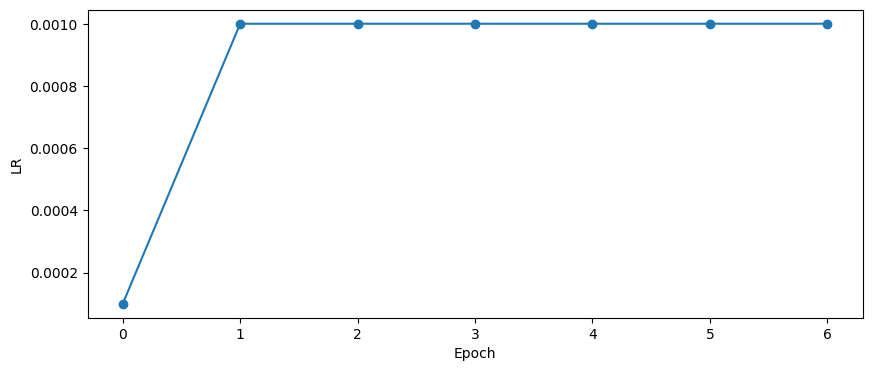

In [5]:
# https://www.kaggle.com/code/cdeotte/tensorflow-transformer-0-790/notebook
LR_START = 1e-4
LR_MAX = 1e-3
LR_MIN = 1e-3
LR_RAMPUP_EPOCHS = 1
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 7

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN    
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))
LR_Scheduler = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [6]:
class CFG:
    train_path = '/kaggle/input/um-game-playing-strength-of-mcts-variants/train.csv'
    split_agent_features = True
    scaler = MinMaxScaler()  # Scaler or None
    folds = 6
    epochs = 7
    batch_size = 128
    LR_Scheduler = [LR_Scheduler]
    optimizer = Adam(learning_rate=1e-3)
    
    conf = ModelConfig(auto_imputation=False,
                       auto_discrete=False,
                       auto_discard_unique=True,
                       categorical_columns='auto',
                       apply_gbm_features=True,
                       fixed_embedding_dim=True,
                       embeddings_output_dim=4,
                       embedding_dropout=0.2,
                       nets=['dnn_nets'] + ['fm_nets'] + ['cin_nets'],
                       dnn_params={
                           'hidden_units': ((1024, 0.0, True),
                                            (512, 0.0, True),
                                            (256, 0.0, True),
                                            (128, 0.0, True)),
                           'dnn_activation': 'relu',
                       },
                       stacking_op='concat',
                       output_use_bias=False,
                       optimizer=optimizer,
                       task='regression',
                       loss='auto',
                       metrics=["RootMeanSquaredError"],
                       earlystopping_patience=1,
                       )

In [7]:
def train_nn(data):
    cv = GroupKFold(n_splits=CFG.folds)
    groups = data[game_col]
    X = data.drop([target_col, game_col], axis=1)
    y = data[target_col]
    oof = np.zeros(len(data))
    models = []
    
    for fi, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups)):
        print("#"*25)
        print(f"### Fold {fi+1}/{CFG.folds} ...")
        print("#"*25)   
        K.clear_session()
        model = DeepTable(config=CFG.conf)
        model.fit(X.iloc[train_idx], y.iloc[train_idx],
                  validation_data=(X.iloc[valid_idx], y.iloc[valid_idx]),
                  callbacks=CFG.LR_Scheduler,
                  batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2)
        models.append(model)
        
        # Avoid some errors
        with K.name_scope(CFG.optimizer.__class__.__name__):
            for j, var in enumerate(CFG.optimizer.weights):
                name = 'variable{}'.format(j)
                CFG.optimizer.weights[j] = tf.Variable(var, name=name)
        CFG.conf = CFG.conf._replace(optimizer=CFG.optimizer)
        
        oof_preds = model.predict(X.iloc[valid_idx], verbose=1, batch_size=512).flatten()
        rmse = np.round(np.sqrt(np.mean((oof_preds - y.iloc[valid_idx])**2)),4)
        print(f'{Fore.GREEN}{Style.BRIGHT}\nFold {fi+1} | rmse: {rmse}\n')
        if fi<CFG.folds: oof[valid_idx] = oof_preds
        else: oof[valid_idx] += oof_preds
            
    rmse = np.round(np.sqrt(np.mean((oof - y)**2)),4)
    print(f'{Fore.BLUE}{Style.BRIGHT}Overall CV rmse: {rmse}\n')
    plot_model(model.get_model().model)
    return models

def infer_nn(data, models):
    return np.mean([model.predict(data, verbose=1, batch_size=512).flatten() for model in models], axis=0)

In [8]:
%%time
run_i = 0
scaler = CFG.scaler
def predict(test_data, submission):
    global run_i, scaler, models
    if run_i == 0:
        train_df = pl.read_csv(CFG.train_path)
        train_df, num_cols = preprocess_data(train_df)
        if scaler is not None:
            print(f'Scaling {len(num_cols)} numerical cols.\n')
            train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
        models = train_nn(train_df)
    run_i += 1
    test_df, num_cols = preprocess_data(test_data)
    test_df = test_df.drop(columns=game_col)
    if scaler is not None:
        print(f'Scaling {len(num_cols)} numerical cols.\n')
        test_df[num_cols] = scaler.transform(test_df[num_cols])
    return submission.with_columns(pl.Series(target_col, infer_nn(test_df, models)))

inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        ('/kaggle/input/um-game-playing-strength-of-mcts-variants/test.csv',
         '/kaggle/input/um-game-playing-strength-of-mcts-variants/sample_submission.csv'))

Data shape: (233234, 598)

Scaling 588 numerical cols.

#########################
### Fold 1/6 ...
#########################
10-19 10:26:21 I deeptables.m.deeptable.py 338 - X.Shape=(194328, 596), y.Shape=(194328,), batch_size=128, config=ModelConfig(name='conf-1', nets=['cin_nets', 'fm_nets', 'dnn_nets'], categorical_columns='auto', exclude_columns=[], task='regression', pos_label=None, metrics=['RootMeanSquaredError'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=False, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=True, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.2, stacking_op='concat', output_use_bias=False, apply_class_weight=False, optimizer=<keras.src.optimizers.legacy.adam.Adam object at 0x7e095da81c30>, loss='

10-19 10:26:23 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



10-19 10:26:23 I deeptables.m.preprocessor.py 261 - Preparing features...
10-19 10:26:24 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.6557238101959229s
10-19 10:26:24 I deeptables.m.preprocessor.py 388 - Categorical encoding...
10-19 10:26:24 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.38260579109191895s
10-19 10:26:24 I deeptables.m.preprocessor.py 423 - Extracting GBM features...
10-19 10:26:25 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.348956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17137
[LightGBM] [Info] Number of data points in the train set: 194328, number of used features: 593
[LightGBM] [Info] Start training from score 0.048944
10-19 10:26:45 I deeptables.m.preprocessor.py 434 - Extracting gbm features taken 20.867204

10-19 10:31:04 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



10-19 10:31:05 I deeptables.m.preprocessor.py 261 - Preparing features...
10-19 10:31:05 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.6524755954742432s
10-19 10:31:05 I deeptables.m.preprocessor.py 388 - Categorical encoding...
10-19 10:31:06 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.3624684810638428s
10-19 10:31:06 I deeptables.m.preprocessor.py 423 - Extracting GBM features...
10-19 10:31:07 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.368980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17176
[LightGBM] [Info] Number of data points in the train set: 194394, number of used features: 593
[LightGBM] [Info] Start training from score 0.049932
10-19 10:31:26 I deeptables.m.preprocessor.py 434 - Extracting gbm features taken 20.5912806

10-19 10:35:40 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



10-19 10:35:40 I deeptables.m.preprocessor.py 261 - Preparing features...
10-19 10:35:41 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.6427521705627441s
10-19 10:35:41 I deeptables.m.preprocessor.py 388 - Categorical encoding...
10-19 10:35:41 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.36602258682250977s
10-19 10:35:41 I deeptables.m.preprocessor.py 423 - Extracting GBM features...
10-19 10:35:42 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.358621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17212
[LightGBM] [Info] Number of data points in the train set: 194328, number of used features: 594
[LightGBM] [Info] Start training from score 0.044576
10-19 10:36:02 I deeptables.m.preprocessor.py 434 - Extracting gbm features taken 20.540232

10-19 10:40:16 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



10-19 10:40:17 I deeptables.m.preprocessor.py 261 - Preparing features...
10-19 10:40:17 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.6498260498046875s
10-19 10:40:17 I deeptables.m.preprocessor.py 388 - Categorical encoding...
10-19 10:40:18 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.3647944927215576s
10-19 10:40:18 I deeptables.m.preprocessor.py 423 - Extracting GBM features...
10-19 10:40:18 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.375267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17149
[LightGBM] [Info] Number of data points in the train set: 194372, number of used features: 583
[LightGBM] [Info] Start training from score 0.038129
10-19 10:40:38 I deeptables.m.preprocessor.py 434 - Extracting gbm features taken 20.5242705

10-19 10:44:55 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



10-19 10:44:55 I deeptables.m.preprocessor.py 261 - Preparing features...
10-19 10:44:56 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.7187507152557373s
10-19 10:44:56 I deeptables.m.preprocessor.py 388 - Categorical encoding...
10-19 10:44:57 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.46407151222229004s
10-19 10:44:57 I deeptables.m.preprocessor.py 423 - Extracting GBM features...
10-19 10:44:57 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.358292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16991
[LightGBM] [Info] Number of data points in the train set: 194374, number of used features: 595
[LightGBM] [Info] Start training from score 0.031522
10-19 10:45:17 I deeptables.m.preprocessor.py 434 - Extracting gbm features taken 20.500153

10-19 10:49:34 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



10-19 10:49:34 I deeptables.m.preprocessor.py 261 - Preparing features...
10-19 10:49:35 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.6511979103088379s
10-19 10:49:35 I deeptables.m.preprocessor.py 388 - Categorical encoding...
10-19 10:49:35 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.43283915519714355s
10-19 10:49:35 I deeptables.m.preprocessor.py 423 - Extracting GBM features...
10-19 10:49:36 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.663775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17062
[LightGBM] [Info] Number of data points in the train set: 194374, number of used features: 587
[LightGBM] [Info] Start training from score 0.053284
10-19 10:50:00 I deeptables.m.preprocessor.py 434 - Extracting gbm features taken 25.3984317779541s
10-19 10:50:02 I deeptables.m.preprocessor.py 196 - fit